# Global preparations

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import time
import torch
import torchvision
import logging
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm.notebook import tqdm

sys.path.insert(0, os.path.expanduser('~/spiky'))
device = 'cuda:3'
summation_dtype = torch.float32
random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)
torch.backends.cudnn.enabled = True
print(torch.__version__)

2.1.2+cu121


# Text data preparation

Let's read tinyshakespeare.txt

In [2]:
CONTEXT_SIZE = 32

In [3]:
from typing import Iterator
import random

import torch


class TextSnippetSampler:
    def __init__(
        self,
        text_file_name: str,
        context_size: int,
        n_test_regions: int,
        device: torch.device,
        random_seed: int = None,
    ):
        self.context_size = context_size
        self.n_test_regions = n_test_regions
        self.device = device

        with open(text_file_name, "rb") as f:
            text_bytes = f.read()

        self.text = torch.tensor(list(text_bytes), dtype=torch.int32, device=device)
        self.text_length = len(self.text)

        # Create testing mask: mark regions of size 2 * context_size as testing
        self.testing_mask = torch.zeros(self.text_length, dtype=torch.bool, device=torch.device('cpu'))

        # Sample random centers for test regions
        # Each test region is 2 * context_size in size
        test_region_size = 2 * context_size
        half_region = test_region_size // 2
        min_center = half_region
        max_center = self.text_length - half_region

        # Create an optional generator for reproducibility
        if random_seed is not None:
            gen = torch.Generator(device=device)
            gen.manual_seed(random_seed)
        else:
            gen = None

        # Centers are sampled uniformly in [min_center, max_center] (inclusive)
        self.test_region_centers_tensor = torch.randint(
            low=min_center,
            high=max_center + 1,
            size=(n_test_regions,),
            dtype=torch.int64,
            device=device,
            generator=gen,
        )
        self.test_region_centers = self.test_region_centers_tensor.tolist()

        # Mark regions around centers as testing
        for center in self.test_region_centers:
            start = max(0, center - half_region)
            end = min(self.text_length, center + half_region)
            self.testing_mask[start:end] = True

    def sample_training_batch(self, batch_size: int) -> torch.Tensor:
        batch = []
        attempts = 0
        max_attempts = batch_size * 100  # Prevent infinite loops

        while len(batch) < batch_size and attempts < max_attempts:
            # Sample random start position
            start = random.randint(0, self.text_length - self.context_size - 1)

            if not self.testing_mask[start].item():
                batch.append(self.text[start:start + self.context_size])

            attempts += 1

        if len(batch) < batch_size:
            raise RuntimeError(
                f"Could not sample {batch_size} training snippets. "
                f"Only found {len(batch)} valid snippets after {attempts} attempts."
            )

        # Stack into batch tensor: (batch_size, context_size + 1)
        return torch.stack(batch, dim=0)

    def testing_batches_iterator(self, batch_size: int) -> Iterator[torch.Tensor]:
        # Collect all testing snippets
        test_snippets = []

        for center in self.test_region_centers:
            # Testing snippet of length context_size starting at the center
            start = center
            end = start + self.context_size

            # Ensure valid range
            if start >= 0 and end <= self.text_length:
                snippet = self.text[start:end]
                test_snippets.append(snippet)

        # Yield batches
        for i in range(0, len(test_snippets), batch_size):
            batch = test_snippets[i:i + batch_size]
            yield torch.stack(batch, dim=0)

    def batch_to_text(self, batch_of_ints):
        assert batch_of_ints.shape[1] == self.context_size
        results = []
        for i in range(batch_of_ints.shape[0]):
            results.append(''.join(chr(int(x)) for x in batch_of_ints[i].tolist()))
        return results

In [4]:
#snippet_sampler = TextSnippetSampler('tinyshakespeare.txt', CONTEXT_SIZE + 1, 1000, device)
snippet_sampler = TextSnippetSampler('fineweb_texts.txt', CONTEXT_SIZE + 1, 1000, device)

In [5]:
snippet_sampler.sample_training_batch(2)

tensor([[110, 101, 115, 104,  99, 104,  97, 110, 100, 114,  97,  32,  83, 101,
         110,  44,  32,  39,  65, 115,  32,  73,  32,  75, 110, 101, 119,  32,
          72, 105, 109,  39,  44],
        [153, 116,  32, 112, 114, 111, 100, 117,  99, 101, 100,  46,  32,  66,
         111, 110, 101,  32, 109,  97, 114, 114, 111, 119,  32, 116, 114,  97,
         110, 115, 112, 108,  97]], device='cuda:3', dtype=torch.int32)

In [6]:
snippet_sampler.batch_to_text(snippet_sampler.sample_training_batch(4))

['the alleged crime. Certain crimes',
 'e disparities impose higher rate ',
 'rdinian armies in northern Italy ',
 ' also been made more culturally r']

In [7]:
for test_batch in snippet_sampler.testing_batches_iterator(4):
    print(snippet_sampler.batch_to_text(test_batch))
    break

[' in any other higher education se', 'n Vidal discovers, other causes a', 'ers, gorillas, and other celebrit', 'ination of their representatives,']


# Baseline character transformer

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Enable all SDP kernels
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)


# ----------------------------------------------------
# Optimized sinusoidal PE (precomputed on GPU/CPU)
# ----------------------------------------------------
def build_sinusoidal_pe(max_len, d_model, device):
    position = torch.arange(max_len, device=device).float().unsqueeze(1)
    inv_freq = torch.exp(
        -torch.arange(0, d_model, 2, device=device).float() * (torch.log(torch.tensor(10000.0)) / d_model)
    )
    sinusoid = position * inv_freq

    pe = torch.empty(max_len, d_model, device=device)
    pe[:, 0::2] = torch.sin(sinusoid)
    pe[:, 1::2] = torch.cos(sinusoid)
    return pe

# ----------------------------------------------------
# SDPA Transformer Encoder Layer
# ----------------------------------------------------
class SDPATransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dim_feedforward, dropout):
        super().__init__()
        assert d_model % n_heads == 0
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
        )

        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x):
        B, T, C = x.shape

        qkv = self.qkv(x).view(B, T, 3, self.n_heads, self.d_head)
        q, k, v = qkv.unbind(dim=2)

        q = q.permute(0, 2, 1, 3)
        k = k.permute(0, 2, 1, 3)
        v = v.permute(0, 2, 1, 3)

        attn = F.scaled_dot_product_attention(
            q, k, v,
            attn_mask=None,
            dropout_p=self.dropout.p if self.training else 0.0,
            is_causal=True,
        )

        attn = attn.permute(0, 2, 1, 3).reshape(B, T, C)
        attn = self.out_proj(attn)

        x = x + self.norm1(self.dropout(attn))
        x = x + self.norm2(self.dropout(self.ffn(x)))
        return x


# ----------------------------------------------------
# Full Transformer Model
# ----------------------------------------------------
class CharTransformer(nn.Module):
    def __init__(
        self,
        vocab_size=256,
        d_model=256,
        n_heads=4,
        num_layers=6,
        max_len=512,
        dropout=0.0,
    ):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len

        # fixed random token embedding
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.token_emb.weight.data.uniform_(-1, 1)
        self.token_emb.weight.requires_grad_(False)

        # precomputed sinusoidal PE
        self.register_buffer("pos_emb", build_sinusoidal_pe(max_len, d_model, device))

        # transformer stack
        self.layers = nn.ModuleList([
            SDPATransformerEncoderLayer(
                d_model, n_heads, 4 * d_model, dropout
            )
            for _ in range(num_layers)
        ])

        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, x, return_all_logits=False):
        B, T = x.shape
        device = x.device

        # move PE to correct device (fast)
        pos = self.pos_emb[:T].to(device)

        h = self.token_emb(x) + pos

        for layer in self.layers:
            h = layer(h)

        logits = self.out(h)
        return logits if return_all_logits else logits[:, -1]

In [12]:
baseline_net = CharTransformer(max_len=CONTEXT_SIZE)
baseline_net.to(device)
x = torch.randint(0, 256, (4, CONTEXT_SIZE), dtype=torch.long, device=device)
logits = baseline_net(x) 
probs = baseline_net(x, True)
logits, probs

(tensor([[ 0.7507,  2.8395,  3.6109,  ...,  0.1548, -1.8844,  0.6803],
         [ 2.8438,  3.0570,  3.2599,  ..., -1.1748, -0.8174,  0.9571],
         [ 1.8724,  2.2938,  5.1686,  ..., -2.0209,  0.3499,  0.6967],
         [ 3.5295,  2.5534,  3.8371,  ..., -1.2205, -0.7210,  0.3148]],
        device='cuda:3', grad_fn=<SelectBackward0>),
 tensor([[[ 0.4054,  2.2889,  3.0516,  ..., -2.1926, -1.9009,  1.9887],
          [ 1.4368,  3.3719,  2.9612,  ..., -1.7321, -0.8535,  0.4140],
          [ 1.3100,  3.8924,  2.6545,  ...,  0.2048, -0.8712,  0.7607],
          ...,
          [ 1.0702,  3.2611,  2.9636,  ..., -1.3337,  0.2698,  0.6365],
          [ 1.4236,  3.8484,  3.3225,  ..., -1.4802, -0.6218,  0.3178],
          [ 0.7507,  2.8395,  3.6109,  ...,  0.1548, -1.8844,  0.6803]],
 
         [[ 4.0676,  2.8505,  3.4874,  ...,  0.0770, -0.8535,  0.6132],
          [ 2.9312,  4.3521,  3.2037,  ..., -0.1235,  0.3556,  0.5607],
          [ 1.9510,  4.0219,  2.6842,  ..., -0.8428, -0.9531,  1.645

In [13]:
import torch
import torch.nn.functional as F
from torch.optim import Adam, SGD

batch_size = 32

def generate_text(model, prefix, length, device):
    # encode prefix -> list of ints 0..255
    ctx = list(prefix.encode("utf-8"))

    for _ in range(length):
        trunc_ctx = ctx[-model.max_len:]
        x = torch.tensor(trunc_ctx, dtype=torch.long, device=device).unsqueeze(0)  # [1, T]
        logits = model(x)                    # [1, 256]
        probs = torch.softmax(logits, dim=-1)[0]
        next_id = torch.multinomial(probs, 1).item()
        ctx.append(next_id)

    return bytes(ctx).decode("latin1", errors="ignore")

def evaluate_model(model, sampler, B):
    model.eval()
    losses = []
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in sampler.testing_batches_iterator(B):   # [B, C]
            inp = batch[:, :-1]          # [B, C-1]
            tgt = batch[:, 1:].long()    # [B, C-1]

            logits = model(inp, return_all_logits=True)   # [B, C-1, 256]

            B_, T, V = logits.shape
            loss = F.cross_entropy(
                logits.reshape(B_ * T, V),
                tgt.reshape(B_ * T),
            )
            losses.append(loss.item())

    # ---- small generation demo ----
    prefix = "Once upon a time "
    gen = generate_text(model, prefix, length=80, device=device)
    print("\n[GEN]:", gen, "\n")

    model.train()
    return sum(losses) / len(losses)

In [14]:
evaluate_model(baseline_net, snippet_sampler, batch_size)


ßqË 



7.111813127994537

In [15]:
total = sum(p.numel() for p in baseline_net.parameters())
trainable = sum(p.numel() for p in baseline_net.parameters() if p.requires_grad)

print("total:", total)
print("trainable:", trainable)
print("frozen:", total - trainable)

total: 4869888
trainable: 4804352
frozen: 65536


In [16]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

def lr_func(t):
    return min(
        1.0 / (1 + t)**0.5,
        (t / 4000.0) / 4000.0**0.5
    )

opt = optim.Adam(baseline_net.parameters(), lr=0.1)
sched = LambdaLR(opt, lr_lambda=lr_func)

In [19]:
train_losses = []
test_losses = []
steps = 10_000
test_every = 1000

In [ ]:
pbar = tqdm(total=steps)
baseline_net.train()
train_loss = None
alpha = 0.01
for step in range(1, steps + 1):
    x = snippet_sampler.sample_training_batch(batch_size)   # [B, C]
    inp = x[:, :-1]                                         # [B, C-1]
    tgt = x[:, 1:].long()                                   # [B, C-1]

    logits = baseline_net(inp, return_all_logits=True)      # [B, C-1, 256]

    B, T, V = logits.shape
    loss = F.cross_entropy(
        logits.reshape(B * T, V),
        tgt.reshape(B * T)
    )

    opt.zero_grad()
    loss.backward()
    opt.step()
    sched.step()

    train_loss = loss.item() if train_loss is None else (1 - alpha) * train_loss + alpha * loss.item()
    pbar.update(1)
    if step % 100 == 0:
        pbar.set_description(f"loss={train_loss:.4f}, lr {sched.get_last_lr()[0]:.4f}")
    

    if step % test_every == 0:
        test_loss = evaluate_model(baseline_net, snippet_sampler, batch_size)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"[TEST] step {step}: loss={test_loss:.4f}")

  0%|          | 0/10000 [00:00<?, ?it/s]


[GEN]: Once upon a time supt any. 
* that are preve tranin lown there curobs. Is with there, it the Sepe 

[TEST] step 1000: loss=1.9111


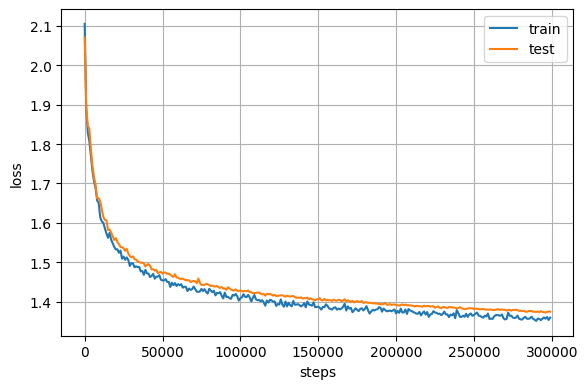

In [16]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

st = [i * 1000 for i in range(len(train_losses))]

plt.figure(figsize=(6,4))
plt.plot(st, train_losses, label="train")
plt.plot(st, test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for CONTEXT_SIZE=32

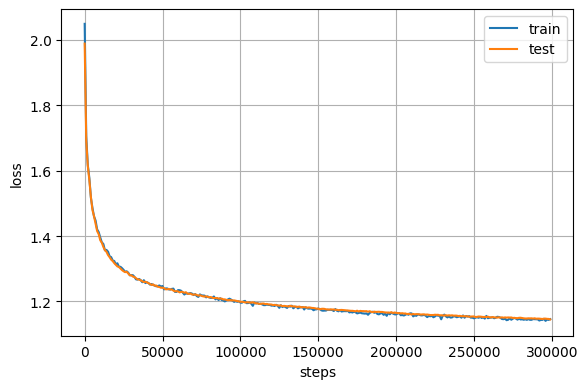

In [95]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

st = [i * 1000 for i in range(len(train_losses))]

plt.figure(figsize=(6,4))
plt.plot(st, train_losses, label="train")
plt.plot(st, test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for CONTEXT_SIZE=64

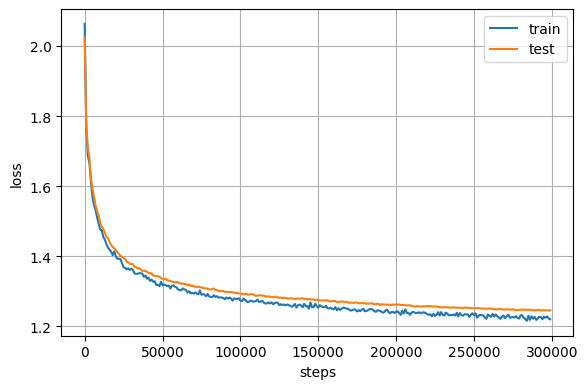

In [80]:
import matplotlib.pyplot as plt

# assume train_losses and test_losses are Python lists of equal length

st = [i * 1000 for i in range(len(train_losses))]

plt.figure(figsize=(6,4))
plt.plot(st, train_losses, label="train")
plt.plot(st, test_losses, label="test")

plt.xlabel("steps")
plt.ylabel("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()